In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from model import *

import scipy.io # To load the matrix
from pyDOE import lhs # For Latin Hypercube samplig method
import numpy as np

In [2]:
# Model name
model_name = 'burgers_1d_pinn_data.pt'

# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
class Net_U(nn.Module):
    def __init__(self,dnn):

        nn.Module.__init__(self)

        self.dnn = dnn

    def forward(self,x,t):
        u = self.dnn(torch.cat([x, t], dim=1))
        return u

In [4]:
class PINN_loss(nn.Module):
    def __init__(self):
        """
        Inputs :
            net_u : 
            net_f
            device : self explenatory, cuda if possible 
        """
        nn.Module.__init__(self)

    def forward(self,u,u_pred):
        loss = torch.mean((u - u_pred) ** 2)

        return loss

In [5]:
# # # Known labels dataset
class u_Dataset(Dataset):
    def __init__(self, inputs, outputs):
        super(Dataset, self).__init__()

        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return self.inputs.shape[0]
        
    def __getitem__(self, index):

        # X 
        X = self.inputs[index, :]

        y = self.outputs[index]
        return X, y

In [6]:
# # # Parameters
nu = 0.01/np.pi
noise = 0.0        

N_f = 10000

data = scipy.io.loadmat('burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]                 

# Clean Domain
idx = np.random.choice(X_star.shape[0], N_f, replace=False)
X_u_train = X_star[idx,:]
u_train = u_star[idx,:]

print('Total training data',X_u_train.shape[0])

Total training data 10000


## Train with : Adam

In [7]:
u_dataset = u_Dataset(X_u_train,u_train)

u_trainloader = DataLoader(u_dataset, batch_size=1010, shuffle=True, num_workers=0)

In [8]:
dnn = Model(in_size=2,neurons_layer=[20,20,20,20,20,20],out_size=1)
dnn = dnn.to(device)

optimizer = torch.optim.Adam(dnn.parameters(), lr=1e-2)

net_u = Net_U(dnn=dnn)

pinn_loss = PINN_loss()

In [9]:
epoch = 2000

tot_loss = []

for i in range(epoch):
    dnn.train()

    epoch_loss = 0

    for X_u, u in u_trainloader:

        x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)

        u = torch.tensor(u, requires_grad=True).float().to(device)
        
        optimizer.zero_grad()

        preds_u = net_u(x_u,t_u)

        loss = pinn_loss(u,preds_u)

        loss.backward()

        optimizer.step()

        # Add loss
        epoch_loss += loss

    tot_loss.append(epoch_loss)

    if i % 100 == 0:
        print('Iter %d, Loss: %.3e' % (i,epoch_loss))

C:\Users\nilso\anaconda3\envs\TORCH\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
C:\Users\nilso\anaconda3\envs\TORCH\lib\site-packages\ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
C:\Users\nilso\anaconda3\envs\TORCH\lib\site-packages\ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
Iter 0, Loss: 3.180e+00
Iter 100, Loss: 3.736e-03
Iter 200, Loss: 4.031e-03
Iter 300, Los

In [10]:
# Save model 
PATH = model_name

torch.save(dnn.state_dict(), PATH)

In [11]:
# Load model
PATH = model_name

model_test = Model(in_size=2,neurons_layer=[20,20,20,20,20,20],out_size=1)
model_test.load_state_dict(torch.load(PATH))
model_test.eval()

Model(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Linear(in_features=20, out_features=20, bias=True)
  )
  (out): Linear(in_features=20, out_features=1, bias=True)
  (tanh): Tanh()
)

In [12]:
# Predictions
net_u = Net_U(dnn=model_test)

x = torch.tensor(X_star[:, 0:1], requires_grad=True).float()
t = torch.tensor(X_star[:, 1:2], requires_grad=True).float()

u_preds = net_u(x, t)

u_preds = u_preds.detach().cpu().numpy()

In [13]:
# Compute Error
error_u = np.linalg.norm(u_star-u_preds,2)/np.linalg.norm(u_star,2)

print(error_u)

0.00757365642683718


In [14]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [15]:
U_pred = griddata(X_star, u_preds.flatten(), (X, T), method='cubic')
U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')
U_error = griddata(X_star, u_star.flatten()-u_preds.flatten(), (X, T), method='cubic')

In [16]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

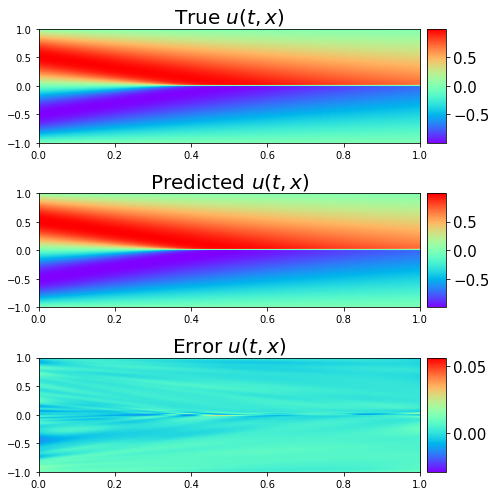

In [17]:
fig = plt.figure(figsize=(7, 7))
ax0 = fig.add_subplot(311)
ax1 = fig.add_subplot(312)
ax2 = fig.add_subplot(313)

h = ax0.imshow(U_star.T,extent=[0, 1, -1, 1], aspect='auto',cmap='rainbow')
ax0.set_title('True $u(t,x)$', fontsize = 20)

divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

h = ax1.imshow(U_pred.T,extent=[0, 1, -1, 1], aspect='auto',cmap='rainbow')
ax1.set_title('Predicted $u(t,x)$', fontsize = 20)

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

h = ax2.imshow(U_error.T,extent=[0, 1, -1, 1], aspect='auto',cmap='rainbow')
ax2.set_title('Error $u(t,x)$', fontsize = 20)

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

plt.tight_layout()

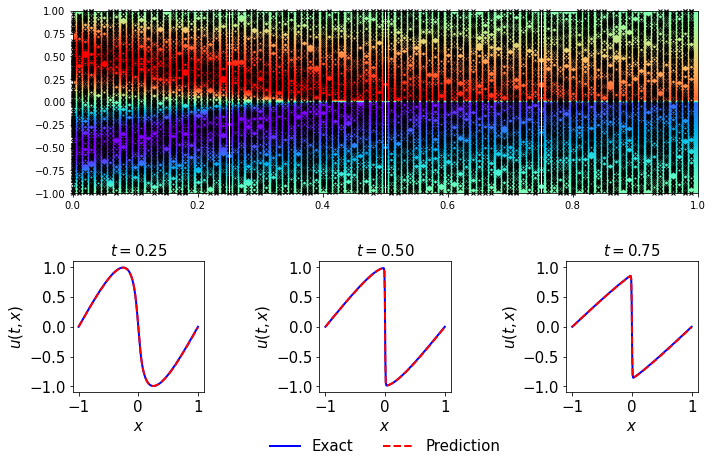

In [18]:
fig = plt.figure(figsize=(10,7))

gs = gridspec.GridSpec(2, 3)

ax = fig.add_subplot(gs[0, :])

h = ax.imshow(U_star.T,extent=[0, 1, -1, 1], aspect='auto',cmap='rainbow')
ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,
    clip_on = False
)
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax0 = fig.add_subplot(gs[1, 0])
ax1 = fig.add_subplot(gs[1, 1])
ax2 = fig.add_subplot(gs[1, 2])

ax0.set_title('$t = 0.25$', fontsize = 15)
ax0.plot(data['x'].flatten()[:,None],Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax0.plot(data['x'].flatten()[:,None],U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax0.axis('square')

ax1.set_title('$t = 0.50$', fontsize = 15)
ax1.plot(data['x'].flatten()[:,None],Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax1.plot(data['x'].flatten()[:,None],U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax1.axis('square')

ax2.set_title('$t = 0.75$', fontsize = 15)
ax2.plot(data['x'].flatten()[:,None],Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax2.plot(data['x'].flatten()[:,None],U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax2.axis('square')

line = np.linspace(data['x'].flatten()[:,None].min(), data['x'].flatten()[:,None].max(), 2)[:,None]
ax.plot(data['t'].flatten()[:,None][25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(data['t'].flatten()[:,None][50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(data['t'].flatten()[:,None][75]*np.ones((2,1)), line, 'w-', linewidth = 1)

for ax in [ax0,ax1,ax2]:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)
    
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1]) 

ax1.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.25), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

plt.tight_layout()

In [20]:
# Analyis : PINN vs Data Driven

# # # Parameters
nu = 0.01/np.pi
noise = 0.0        

data = scipy.io.loadmat('burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]                 

# Start for loop 
for N_f in [10,20,50,100,200,500,1000,2000,5000,10000]:

    # Clean Domain
    idx = np.random.choice(X_star.shape[0], N_f, replace=False)
    X_u_train = X_star[idx,:]
    u_train = u_star[idx,:]

    print('Total training data',X_u_train.shape[0])

    u_dataset = u_Dataset(X_u_train,u_train)
    u_trainloader = DataLoader(u_dataset, batch_size=int(N_f/10), shuffle=True, num_workers=0)

    dnn = Model(in_size=2,neurons_layer=[20,20,20,20,20,20],out_size=1)
    dnn = dnn.to(device)

    optimizer = torch.optim.Adam(dnn.parameters(), lr=1e-2)

    net_u = Net_U(dnn=dnn)

    pinn_loss = PINN_loss()

    epoch = 2000

    tot_loss = []

    for i in range(epoch):
        dnn.train()

        epoch_loss = 0

        for X_u, u in u_trainloader:

            x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
            t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)

            u = torch.tensor(u, requires_grad=True).float().to(device)
        
            optimizer.zero_grad()

            preds_u = net_u(x_u,t_u)

            loss = pinn_loss(u,preds_u)

            loss.backward()

            optimizer.step()

            # Add loss
            epoch_loss += loss

        tot_loss.append(epoch_loss)

        if i % 100 == 0:
            print('Iter %d, Loss: %.3e' % (i,epoch_loss))
    
    PATH = f'burgers_1d_pinn_data_{N_f}.pt'
    torch.save(dnn.state_dict(), PATH)

Total training data 10
C:\Users\nilso\anaconda3\envs\TORCH\lib\site-packages\ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\nilso\anaconda3\envs\TORCH\lib\site-packages\ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\nilso\anaconda3\envs\TORCH\lib\site-packages\ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Iter 0, Loss: 6.191e+00
Iter 100, Loss: 5.137e-03
Iter 200, Loss: 1.277e+00
Iter 300, Loss: 1.168e+00
Iter 400, Loss: 1.182e+00
Iter 500, Loss: 1.411